In [259]:
import json
import numpy as np
import random
from tqdm import tqdm
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD
import re
import matplotlib.pyplot as plt
import sklearn
import scipy
from sklearn.preprocessing import normalize

In [260]:
def rand_emot():
    e = ["(o_o)",":-)",":P",":D","x)","ᓚᘏᗢ","╯°□°）╯︵ ┻━┻",":)",
         "*<:-)","^_^","(⌐■_■)","¯\_(ツ)_/¯", "(T_T)",":o","OwO",
        "( ͡❛ ͜ʖ ͡❛)","(̶◉͛‿◉̶)","( ≖.≖)","(ㆆ_ㆆ)","ʕ•́ᴥ•̀ʔっ","( ◡́.◡̀)","(^◡^ )"]
    return random.choice(e)

def load_files():
    text_pairs = [] #Would be nice to have as np.array
    labels = []
    fandom = []
    
    pair_id = []
    true_id = []
    
    #Load truth JSON
    for line in open('data/modified/train_truth.jsonl'):
        d = json.loads(line.strip())
        labels.append(int(d['same']))
        true_id.append(d['id'])

    #Load actual fanfic.
    print("loading fanfic...",rand_emot())
    for line in tqdm(open('data/modified/train_pair.jsonl')):
        d = json.loads(line.strip())
        text_pairs.append(d['pair'])
        fandom.append(d['fandoms'])
        pair_id.append(d['id'])

    print("done loading",rand_emot())
    
    return text_pairs, labels, fandom, pair_id, true_id

In [261]:
text_pairs, labels, fandom, pair_id, true_id = load_files()

635it [00:00, 3137.80it/s]

loading fanfic... ( ≖.≖)


1578it [00:00, 2979.71it/s]

done loading (⌐■_■)


In [262]:
def create_corpus(text_pairs):
    '''input all text pairs to create a corpus'''
    corpus = [x[i] for x in text_pairs for i in range(len(x))]
    return corpus

In [274]:
corpus = create_corpus(text_pairs)[:1000] #Only take the 100 first texts - to make it faster
labels = labels[:500]

## PCA Function

In [264]:
def show_me_pca(vector, labels, is_pairs=False, title=""):
    '''Plot PCA for the two classes. Input is one long vector/list, it creates pairs itself.
    If you already created pairs, use is_pairs=True
    Example: if vector is distance between pairs, do not set is_pairs to True. 
    (as it is one vector describing both documents.)
    
    labels is simply a vector with the labels, which will be used to colour the scatter plot.'''
    
    #Convert labels to np.array (might be a list.)
    labels = np.array(labels)
    
    #Join pairs into one, long vector if necessary. 
    if not is_pairs:
        if scipy.sparse.issparse(vector):
            vector = [np.hstack([vector[x],vector[x+1]]) for x in range(0,vector.shape[0],2)]  
        else:
            vector = [np.hstack([vector[x],vector[x+1]]) for x in range(0,len(vector),2)]  
    
    #Get that PCA - Use SVD if vector is sparse.
    if scipy.sparse.issparse(vector):
        
        pca = TruncatedSVD(n_components=2)
    else:
        pca = PCA(n_components=2)
    pcs = pca.fit_transform(vector)
    
    #Printing pcs shape - remember they might be halved, due to pairing. 
    print(pcs.shape)
    
    #Group PC's into two, according to label indices. 
    group1 = pcs[labels==0]
    group2 = pcs[labels==1]
    
    #Plot that shit!
    plt.scatter(group1[:,0], group1[:,1], s=5)
    plt.scatter(group2[:,0], group2[:,1], s=5)
    plt.title(title)

## Function Word Feature Exploration

In [302]:
#Isolate function words

with open('data/function_words_clean.txt', "r") as fw:
    func_words = fw.read().split()

def isolate_fw(corpus, f_words): #data must be json file - input must be path to file 
    fw_in_data = []

    for text in tqdm(corpus):
        function_words = []
        words = text.split() #split fanfic into words in list
        for word in words: 
            if word in f_words: #if the word is a function word
                function_words.append(word)
                
        stringed_function_words = " ".join(function_words)
        
        #append all function words as one long string in a list
        fw_in_data.append(stringed_function_words) #fw_in_data is a list with strings
        #each list contains a string of all function words for each pair
        #should it be a string for each pair?
        
    return fw_in_data

In [303]:
function_words = isolate_fw(corpus, func_words)
fw_tokens = [nltk.word_tokenize(x) for x in function_words]
unigram_freqdists = [nltk.FreqDist(x) for x in fw_tokens]
bigrams = [nltk.bigrams(x) for x in fw_tokens]
bigram_freqdists = [nltk.FreqDist(x) for x in bigrams]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.94it/s]


In [304]:
def get_mat_from_fdists(fdists):
    '''This function compiles a list of frequency distributions and create a matrix with feature vectors.
    Each row is a feature vector. Should would with all typed of dictionaries, actually.'''
    all_keys = list(set([item for sublist in fdists for item in sublist]))
    matrix = np.zeros((len(fdists),len(all_keys)))
    
    for i, fd in enumerate(tqdm(fdists)):
        for j, key in enumerate(all_keys):
            matrix[i,j] = fd[key]
    
    return matrix

In [315]:
v1 = normalize(get_mat_from_fdists(unigram_freqdists))
#v2 = get_mat_from_fdists(bigram_freqdists)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8569.62it/s]


(500, 2)


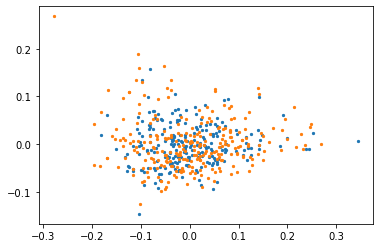

In [322]:
compile_pairs = [v1[x]*v1[x+1] for x in range(0,v1.shape[0],2)]
show_me_pca(compile_pairs, labels, is_pairs=True)